In [1]:
import pickle
import matplotlib.pyplot as plt
import adaptive_latents as al
import glob
import subprocess
import numpy as np
import time

In [2]:
switch_iteration = 400
subprocess.call(["python", "run_partial_start.py", "gpu", str(switch_iteration)])
subprocess.call(["python", "run_partial_start.py", "cpu", str(switch_iteration)])

# these are to compare e.g. "cpu" vs "cpu cpu"
subprocess.call(["python", "run_partial_start.py", "gpu", "None"])
subprocess.call(["python", "run_partial_start.py", "cpu", "None"])

subprocess.call(["python", "run_partial_finish.py", "gpu", "2"])
subprocess.call(["python", "run_partial_finish.py", "cpu", "4"])

backends = ["gpu", "cpu"]

In [3]:
files = sorted(glob.glob(f"{al.CONFIG["output_path"]/"bubblewrap_runs"}/*.pickle"))
brs = []
for file in files[-6:]:
    with open(file, 'br') as fhan:
        brs.append(pickle.load(fhan))
brs = np.array(brs)
brs = brs.reshape(-1,2)

370
372


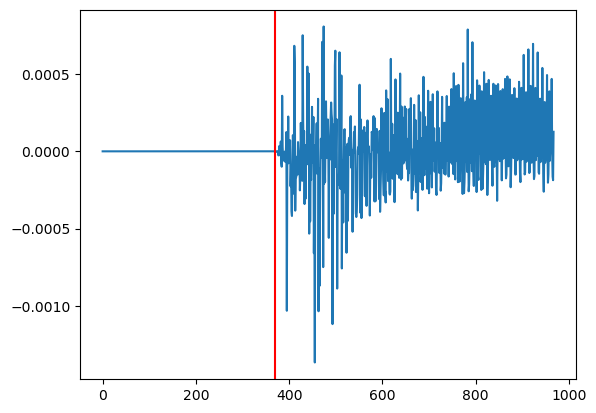

In [4]:
plt.plot(brs[0,1].entropy_history[1] - brs[-1,1].entropy_history[1])
plt.axvline(switch_iteration-brs[0,0].bw.M, color='red')
print(switch_iteration - brs[0,0].bw.M)
print(np.nonzero(brs[0,1].entropy_history[1] - brs[-1,1].entropy_history[1] > 0)[0][0])

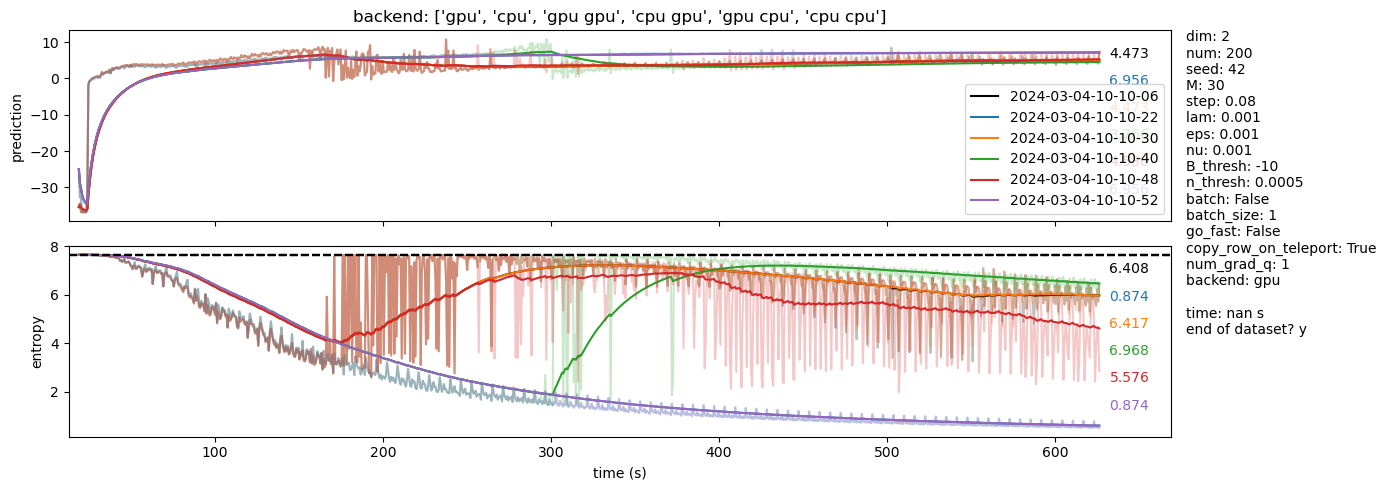

In [7]:
%matplotlib inline
# red_lines=[brs[0,0].obs_ds.t[switch_iteration]]
al.plotting_functions.compare_metrics(brs.flatten(), 1)

/tmp/ipykernel_205003/2004039360.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  ratios.append(s.max() / s.min())


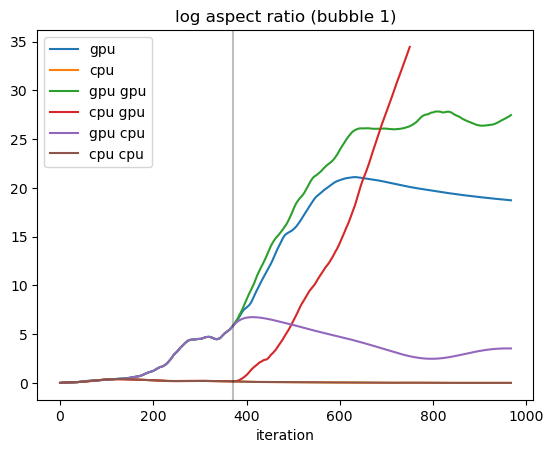

In [6]:
def show_aspect_ratio_divergence(brs, bubble=5, switch=250):
    fig,ax = plt.subplots()
    
    m = bubble
    for k in range(len(brs)):
        ratios = []
        for i in range(brs[k].L_history.shape[0]):
            L = brs[k].L_history[i,m,...]
            _, s, _= np.linalg.svd(np.linalg.pinv(L.T@L))
            ratios.append(s.max() / s.min())
        ratios = np.log(ratios)
        ax.plot(ratios, label=brs[k].bw.backend_note)
    
    ax.set_title(f"log aspect ratio (bubble {m})");
    ax.legend();
    ax.axvline(switch-brs[0].bw.M, color='k', alpha=.25);
    ax.set_xlabel("iteration");
show_aspect_ratio_divergence(brs.flatten(), bubble=1, switch=switch_iteration)